<a href="https://colab.research.google.com/github/nifemi-alonge/evcs_spatial_analysis/blob/main/Alonge_O_Dissertation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of EVCS location inequity and network constraint inequity in London

In [ ]:
# type of analysis
# chi square
# pearsons correlation
# morans eye
# gwr
# spatial lag and error models
# regression on survey data not spatial - binary logistic regression with stepwise forward inclusion of the independent variables
# check data doesnt need normalising

## Packages

In [ ]:
!pip install geodatasets

In [177]:
# import packages
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import geodatasets
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point

## Loading in Data

### NCR

In [ ]:
# DELETE

# API CALL NOT WORKIN|G
# coords of locations to pull

ncr_data = []

# run api call
url = "http://chargepoints.dft.gov.uk/api/retrieve/registry/format/json/country/gb/post-town/greater+london/limit/10"
#url = "http://chargepoints.dft.gov.uk/api/retrieve/registry/format/json/country/gb/lat/51.530377562714435/long/-0.07710211534177956/dist/10/limit/20"
response = requests.get(url)
data = json.loads(response.text)
ncr_data.append(data)
print(ncr_data)

In [75]:
# downloaded on 8th July 2023 from https://www.gov.uk/guidance/find-and-use-data-on-public-electric-vehicle-chargepoints
ncr_data = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/national-charge-point-registry.csv")
ncr_data.shape

<ipython-input-75-eb4afcf40378>:2: DtypeWarning: Columns (5,10,11,16,17,18,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,79,90,101,112,115,119,122,123,126,130,133,134,137,141,144,148,152,155) have mixed types. Specify dtype option on import or set low_memory=False.
  ncr_data = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/national-charge-point-registry.csv")


(31662, 158)

In [76]:
# subset columns
ncr_data = ncr_data[['chargeDeviceID', 'reference', 'name','latitude',
                     'longitude','thoroughfare','street','town','county',
                     'postcode','countryCode','deviceOwnerName',
                     'chargeDeviceStatus','onStreetFlag','locationType']]

ncr_data = ncr_data.loc[ncr_data['county'] == 'Greater London']
#ncr_data.shape()
ncr_data.head()

,chargeDeviceID,reference,name,latitude,longitude,thoroughfare,street,town,county,postcode,countryCode,deviceOwnerName,chargeDeviceStatus,onStreetFlag,locationType
1,fa6c94460e902005a0b660266190c8ba,PP-12295,Ancaster Nissan Dealership,51.411173,-0.055369,Croydon Road,NaN,Anerley,Greater London,SE20 7TF,gb,POD Point,In service,1.0,Dealership forecourt
2,eb1848290d5a7de9c9ccabc67fefa211,PP-12290,Beadles Nissan Ltd,51.451127,0.050619,Eltham High Street,NaN,Eltham,Greater London,SE9 1DH,gb,POD Point,In service,1.0,Other
4,65b1e92c585fd4c2159d5f33b5030ff2,PP-12198,Circus Road,51.533633,-0.172353,Circus Road,NaN,St. John's Wood,Greater London,NW8 6PE,gb,POD Point,In service,1.0,Other
11,7fa215c9efebb3811a7ef58409907899,PP-12283,Glyn Hopkin Nissan Dealership,51.574484,0.160184,London Road,NaN,Romford,Greater London,RM7 9NP,gb,POD Point,In service,1.0,Dealership forecourt
14,c6d6445d97e06d08b60853156601cf58,PP-12432,HMP Belmarsh,51.496067,0.093083,Belmarsh Road,NaN,Thamesmead,Greater London,SE28 0EB,gb,POD Point,In service,1.0,Other


### Census Boundaries

In [5]:
oa_bound = gpd.read_file("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/OA_2011_London_gen_MHW.shp")
oa_bound.head()

,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,LSOA11NM,MSOA11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E00023264,E01004612,E02000954,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 032C,Wandsworth 032,462,459,3,115.2,143,3.2,"POLYGON ((527635.452 171810.058, 527495.957 17..."
1,E00003359,E01000692,E02000128,E05000111,Chislehurst,E09000006,Bromley,E12000007,London,Bromley 002D,Bromley 002,269,259,10,36.7,133,1.9,"POLYGON ((543581.516 171132.486, 543704.000 17..."
2,E00023266,E01004615,E02000956,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 034B,Wandsworth 034,277,277,0,183.4,133,2.1,"POLYGON ((526613.539 171839.165, 526546.840 17..."
3,E00020264,E01004027,E02000809,E05000548,Riverside,E09000028,Southwark,E12000007,London,Southwark 003E,Southwark 003,415,415,0,96.1,191,2.2,"POLYGON ((533563.521 179695.146, 533351.118 17..."
4,E00023263,E01004613,E02000955,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 033D,Wandsworth 033,304,304,0,165.2,131,2.3,"POLYGON ((527822.000 172020.000, 527979.000 17..."


<Axes: >

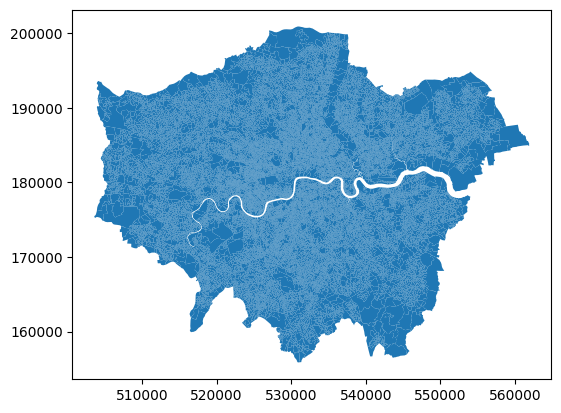

In [ ]:
oa_bound.plot()

### Ethnicity

In [6]:
# ethnic
# Load the census data into a pandas DataFrame
ethnic = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS021-2021-3-filtered-2023-07-08T16_16_10Z_ethnic.csv")

# Print the column names to verify correctness
print(ethnic.columns)

# Specify the column names for ethnicity and respondent count
ethnicity_column = 'Ethnic group (20 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
ethnicity_mapping = {
    'Asian, Asian British or Asian Welsh: Bangladeshi': 'Asian',
    'Asian, Asian British or Asian Welsh: Chinese': 'Asian',
    'Asian, Asian British or Asian Welsh: Indian': 'Asian',
    'Asian, Asian British or Asian Welsh: Other Asian': 'Asian',
    'Asian, Asian British or Asian Welsh: Pakistani': 'Asian',
    'Black, Black British, Black Welsh, Caribbean or African: African': 'Black',
    'Black, Black British, Black Welsh, Caribbean or African: Caribbean': 'Black',
    'Black, Black British, Black Welsh, Caribbean or African: Other Black': 'Black',
    'Mixed or Multiple ethnic groups: Other Mixed or Multiple ethnic groups': 'Mixed',
    'Mixed or Multiple ethnic groups: White and Asian': 'Mixed',
    'Mixed or Multiple ethnic groups: White and Black African': 'Mixed',
    'Mixed or Multiple ethnic groups: White and Black Caribbean': 'Mixed',
    'Other ethnic group: Any other ethnic group': 'Other',
    'Other ethnic group: Arab': 'Other',
    'White: English, Welsh, Scottish, Northern Irish or British': 'White',
    'White: Gypsy or Irish Traveller': 'White',
    'White: Irish': 'White',
    'White: Other White': 'White',
    'White: Roma': 'White',
    'Does not apply': 'NA'
    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
ethnic[ethnicity_column] = ethnic[ethnicity_column].map(ethnicity_mapping).fillna(ethnic[ethnicity_column])

# Group the data by output area and calculate the total respondents
grouped_data = ethnic.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
ethnicities_of_interest = ['Black', 'White']  # Add more ethnicities as needed
ethnicity_data = ethnic[ethnic[ethnicity_column].isin(ethnicities_of_interest)]

# Group the filtered data by output area and calculate the counts
ethnicity_counts = ethnicity_data.groupby(['Output Areas', ethnicity_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
ethnicity_pivot = ethnicity_counts.reset_index().pivot(index='Output Areas', columns=ethnicity_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(ethnicity_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for ethnicity in ethnicities_of_interest:
    merged_data[f'percentage_{ethnicity.lower()}'] = (merged_data[ethnicity] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
ethnic = merged_data

ethnic = ethnic.reset_index()

ethnic = ethnic.rename(columns = {'Output Areas': 'OA11CD'})
ethnic

Index(['Output Areas Code', 'Output Areas',
       'Ethnic group (20 categories) Code', 'Ethnic group (20 categories)',
       'Observation'],
      dtype='object')


,OA11CD,Observation,Black,White,percentage_black,percentage_white
0,E00000001,176,3,155,1.704545,88.068182
1,E00000003,255,5,209,1.960784,81.960784
2,E00000005,112,0,85,0.000000,75.892857
3,E00000007,144,2,106,1.388889,73.611111
4,E00000010,175,12,120,6.857143,68.571429
...,...,...,...,...,...,...
26364,E00190465,301,17,109,5.647841,36.212625
26365,E00190466,606,55,181,9.075908,29.867987
26366,E00190467,407,28,165,6.879607,40.540541
26367,E00190468,260,14,153,5.384615,58.846154


### Population Density

In [7]:
# pop density
pop_density = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/1903010332763141_pop_density.csv")
pop_density = pop_density.rename(columns = {'region': 'OA11CD','Usual residents per square kilometre' :'pop_density'})
pop_density = pop_density.dropna()
pop_density

,OA11CD,mnemonic,pop_density
0,E00000138,E00000138,7395.1
1,E00000156,E00000156,386.4
2,E00000157,E00000157,8934.6
3,E00000158,E00000158,2044.0
4,E00000160,E00000160,4101.1
...,...,...,...
26364,E00023981,E00023981,11968.5
26365,E00175202,E00175202,37948.7
26366,E00175203,E00175203,33170.7
26367,E00175258,E00175258,36744.2


### Household Deprivation

In [9]:
# household deprivation
# Load the census data into a pandas DataFrame
hh_dep = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS011-2021-4-filtered-2023-07-08T18_12_32Z_hh_dep.csv")

# Print the column names to verify correctness
print(hh_dep.columns)

# Specify the column names for ethnicity and respondent count
h_column = 'Household deprivation (6 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
h_mapping = {
    'Household is not deprived in any dimension': 'Not_deprived',
    'Household is deprived in one dimensions': 'Deprived',
    'Household is deprived in two dimensions': 'Deprived',
    'Household is deprived in three dimensions': 'Deprived',
    'Household is deprived in four dimensions': 'Deprived',
    'Does not apply': 'NA'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
hh_dep[h_column] = hh_dep[h_column].map(h_mapping).fillna(hh_dep[h_column])

# Group the data by output area and calculate the total respondents
grouped_data = hh_dep.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
dep_of_interest = ['Deprived', 'Not_deprived']  # Add more ethnicities as needed
h_data = hh_dep[hh_dep[h_column].isin(dep_of_interest)]

# Group the filtered data by output area and calculate the counts
h_counts = h_data.groupby(['Output Areas', h_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
h_pivot = h_counts.reset_index().pivot(index='Output Areas', columns=h_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(h_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for h_dep in dep_of_interest:
    merged_data[f'percentage_{h_dep.lower()}'] = (merged_data[h_dep] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
hh_dep = merged_data

hh_dep = hh_dep.reset_index()

hh_dep = hh_dep.rename(columns = {'Output Areas': 'OA11CD'})
hh_dep

Index(['Output Areas Code', 'Output Areas',
       'Household deprivation (6 categories) Code',
       'Household deprivation (6 categories)', 'Observation'],
      dtype='object')


,OA11CD,Observation,Deprived,Not_deprived,percentage_deprived,percentage_not_deprived
0,E00000001,91,3,66,3.296703,72.527473
1,E00000003,109,5,74,4.587156,67.889908
2,E00000005,65,2,48,3.076923,73.846154
3,E00000007,86,2,69,2.325581,80.232558
4,E00000010,126,30,40,23.809524,31.746032
...,...,...,...,...,...,...
26364,E00190465,179,6,135,3.351955,75.418994
26365,E00190466,242,54,109,22.314050,45.041322
26366,E00190467,214,15,146,7.009346,68.224299
26367,E00190468,114,11,73,9.649123,64.035088


### Household Size

In [10]:
# household size option 1 keep

# household deprivation
# Load the census data into a pandas DataFrame
hh_size = pd.read_csv('/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS017-2021-3-filtered-2023-07-08T18_47_51Z_hh_size.csv')

# Print the column names to verify correctness
print(hh_size.columns)

# Specify the column names for ethnicity and respondent count
h_column = 'Household size (9 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
h_mapping = {
    '0 people in household': 'None_hh',
    '1 people in household': 'Small_hh',
    '2 people in household': 'Small_hh',
    '3 people in household': 'Medium_hh',
    '4 people in household': 'Medium_hh',
    '5 people in household': 'Large_hh',
    '6 people in household': 'Large_hh',
    '7 people in household': 'Large_hh',
    '8 people in household': 'Large_hh'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
hh_size[h_column] = hh_size[h_column].map(h_mapping).fillna(hh_size[h_column])

# Group the data by output area and calculate the total respondents
grouped_data = hh_size.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
hhs_of_interest = ['Small_hh', 'Medium_hh', 'Large_hh']  # Add more ethnicities as needed
h_data = hh_size[hh_size[h_column].isin(hhs_of_interest)]

# Group the filtered data by output area and calculate the counts
h_counts = h_data.groupby(['Output Areas', h_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
h_pivot = h_counts.reset_index().pivot(index='Output Areas', columns=h_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(h_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for hs in hhs_of_interest:
    merged_data[f'percentage_{hs.lower()}'] = (merged_data[hs] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
hh_size = merged_data

hh_size = hh_size.reset_index()

hh_size = hh_size.rename(columns = {'Output Areas': 'OA11CD'})
hh_size

Index(['Output Areas Code', 'Output Areas',
       'Household size (9 categories) Code', 'Household size (9 categories)',
       'Observation'],
      dtype='object')


,OA11CD,Observation,Large_hh,Medium_hh,Small_hh,percentage_small_hh,percentage_medium_hh,percentage_large_hh
0,E00000001,94,0,16,44,46.808511,17.021277,0.000000
1,E00000003,109,4,36,42,38.532110,33.027523,3.669725
2,E00000005,63,0,10,27,42.857143,15.873016,0.000000
3,E00000007,87,1,4,44,50.574713,4.597701,1.149425
4,E00000010,125,3,7,19,15.200000,5.600000,2.400000
...,...,...,...,...,...,...,...,...
26364,E00190465,179,2,22,55,30.726257,12.290503,1.117318
26365,E00190466,242,20,84,74,30.578512,34.710744,8.264463
26366,E00190467,212,9,44,53,25.000000,20.754717,4.245283
26367,E00190468,118,7,34,41,34.745763,28.813559,5.932203


In [ ]:
# delete?
# household size option 2

# Load the census data into a pandas DataFrame
hh_size = pd.read_csv('/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS017-2021-3-filtered-2023-07-08T18_47_51Z_hh_size.csv')

# Print the column names to verify correctness
print(hh_size.columns)

# Specify the column names for household size and respondent count
household_size_column = 'Household size (9 categories) Code'
respondent_count_column = 'Observation'

# Group the data by output area and calculate the total respondents
grouped_data = hh_size.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Pivot the data to convert household sizes into columns
household_size_pivot = hh_size.pivot_table(index='Output Areas', columns=household_size_column, values=respondent_count_column, aggfunc='sum')

# Merge the total respondents and household size counts
merged_data = grouped_data.merge(household_size_pivot, on='Output Areas')

# Calculate the percentages for each household size
household_size_columns = merged_data.columns[1:]  # Exclude the 'Output Areas' column
for size in household_size_columns:
    merged_data[f'percentage_{size}'] = (merged_data[size] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{size}' for size in household_size_columns]])
hh_size = merged_data

hh_size = hh_size.reset_index()

hh_size = hh_size.rename(columns = {'Output Areas': 'OA11CD'})
hh_size

Index(['Output Areas Code', 'Output Areas',
       'Household size (9 categories) Code', 'Household size (9 categories)',
       'Observation'],
      dtype='object')


,OA11CD,Observation,0,1,2,3,4,5,6,7,8,percentage_0,percentage_1,percentage_2,percentage_3,percentage_4,percentage_5,percentage_6,percentage_7,percentage_8
0,E00000001,94,0,34,44,10,6,0,0,0,0,0.0,36.170213,46.808511,10.638298,6.382979,0.000000,0.000000,0.000000,0.000000
1,E00000003,109,0,27,42,19,17,4,0,0,0,0.0,24.770642,38.532110,17.431193,15.596330,3.669725,0.000000,0.000000,0.000000
2,E00000005,63,0,26,27,8,2,0,0,0,0,0.0,41.269841,42.857143,12.698413,3.174603,0.000000,0.000000,0.000000,0.000000
3,E00000007,87,0,38,44,2,2,1,0,0,0,0.0,43.678161,50.574713,2.298851,2.298851,1.149425,0.000000,0.000000,0.000000
4,E00000010,125,0,96,19,4,3,3,0,0,0,0.0,76.800000,15.200000,3.200000,2.400000,2.400000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26364,E00190465,179,0,100,55,12,10,1,0,1,0,0.0,55.865922,30.726257,6.703911,5.586592,0.558659,0.000000,0.558659,0.000000
26365,E00190466,242,0,64,74,49,35,16,4,0,0,0.0,26.446281,30.578512,20.247934,14.462810,6.611570,1.652893,0.000000,0.000000
26366,E00190467,212,0,106,53,25,19,6,3,0,0,0.0,50.000000,25.000000,11.792453,8.962264,2.830189,1.415094,0.000000,0.000000
26367,E00190468,118,0,36,41,18,16,4,3,0,0,0.0,30.508475,34.745763,15.254237,13.559322,3.389831,2.542373,0.000000,0.000000


### Education

In [11]:
# edu

# household deprivation
# Load the census data into a pandas DataFrame
edu = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS067-2021-3-filtered-2023-07-08T19_58_31Z_edu.csv")

# Print the column names to verify correctness
print(edu.columns)

# Specify the column names for ethnicity and respondent count
e_column = 'Highest level of qualification (8 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
e_mapping = {
    'Does not apply': 'NA',
    'No qualifications': 'No_edu',
    'Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills': 'School_edu',
    'Level 2 qualifications: 5 or more GCSEs (A* to C or 9 to 4), O levels (passes), CSEs (grade 1), School Certification, 1 A level, 2 to 3 AS levels, VCEs, Intermediate or Higher Diploma, Welsh Baccalaureate Intermediate Diploma, NVQ level 2, Intermediate GNVQ, City and Guilds Craft, BTEC First or General Diploma, RSA Diploma': 'School_edu',
    'Apprenticeship': 'Other_edu',
    'Level 3 qualifications: 2 or more A levels or VCEs, 4 or more AS levels, Higher School Certificate, Progression or Advanced Diploma, Welsh Baccalaureate Advance Diploma, NVQ level 3; Advanced GNVQ, City and Guilds Advanced Craft, ONC, OND, BTEC National, RSA Advanced Diploma': 'School_edu',
    'Level 4 qualifications or above: degree (BA, BSc), higher degree (MA, PhD, PGCE), NVQ level 4 to 5, HNC, HND, RSA Higher Diploma, BTEC Higher level, professional qualifications (for example, teaching, nursing, accountancy)': 'University_edu',
    'Other: vocational or work-related qualifications, other qualifications achieved in England or Wales, qualifications achieved outside England or Wales (equivalent not stated or unknown)': 'Other_edu'



    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
edu[e_column] = edu[e_column].map(e_mapping).fillna(edu[e_column])

# Group the data by output area and calculate the total respondents
grouped_data = edu.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
e_of_interest = ['No_edu', 'School_edu', 'University_edu']  # Add more ethnicities as needed
e_data = edu[edu[e_column].isin(e_of_interest)]

# Group the filtered data by output area and calculate the counts
h_counts = e_data.groupby(['Output Areas', e_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
e_pivot = h_counts.reset_index().pivot(index='Output Areas', columns=e_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(e_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for e_dep in e_of_interest:
    merged_data[f'percentage_{e_dep.lower()}'] = (merged_data[e_dep] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
edu = merged_data

edu = edu.reset_index()

edu = edu.rename(columns = {'Output Areas': 'OA11CD'})
edu

Index(['Output Areas Code', 'Output Areas',
       'Highest level of qualification (8 categories) Code',
       'Highest level of qualification (8 categories)', 'Observation'],
      dtype='object')


,OA11CD,Observation,No_edu,School_edu,University_edu,percentage_no_edu,percentage_school_edu,percentage_university_edu
0,E00000001,175,4,28,122,2.285714,16.000000,69.714286
1,E00000003,257,5,31,184,1.945525,12.062257,71.595331
2,E00000005,113,3,12,88,2.654867,10.619469,77.876106
3,E00000007,144,5,14,117,3.472222,9.722222,81.250000
4,E00000010,179,15,56,93,8.379888,31.284916,51.955307
...,...,...,...,...,...,...,...,...
26364,E00190465,298,18,46,203,6.040268,15.436242,68.120805
26365,E00190466,602,55,114,271,9.136213,18.936877,45.016611
26366,E00190467,412,19,72,229,4.611650,17.475728,55.582524
26367,E00190468,263,20,45,149,7.604563,17.110266,56.653992


### Car

In [12]:
# CHANGE TO CAR
# number of cars
# Load the census data into a pandas DataFrame
car = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS045-2021-4-filtered-2023-07-08T20_45_48Z_car.csv")

# Print the column names to verify correctness
print(car.columns)

# Specify the column names for ethnicity and respondent count
c_column = 'Car or van availability (5 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
c_mapping = {
    'Does not apply': 'NA',
    'No cars or vans in household': 'No_cars',
    '1 car or van in household': 'One_car',
    '2 cars or vans in household': '2+_cars',
    '3 or more cars or vans in household': '2+_cars'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
car[c_column] = car[c_column].map(c_mapping).fillna(car[c_column])

# Group the data by output area and calculate the total respondents
grouped_data = car.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
c_of_interest = ['No_cars', 'One_car', '2+_cars']  # Add more ethnicities as needed
c_data = car[car[c_column].isin(c_of_interest)]

# Group the filtered data by output area and calculate the counts
c_counts = c_data.groupby(['Output Areas', c_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
c_pivot = c_counts.reset_index().pivot(index='Output Areas', columns=c_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(c_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for car_no in c_of_interest:
    merged_data[f'percentage_{car_no.lower()}'] = (merged_data[car_no] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
car = merged_data

car = car.reset_index()

car = car.rename(columns = {'Output Areas': 'OA11CD'})
car

Index(['Output Areas Code', 'Output Areas',
       'Car or van availability (5 categories) Code',
       'Car or van availability (5 categories)', 'Observation'],
      dtype='object')


,OA11CD,Observation,2+_cars,No_cars,One_car,percentage_no_cars,percentage_one_car,percentage_2+_cars
0,E00000001,95,8,46,41,48.421053,43.157895,8.421053
1,E00000003,109,11,51,47,46.788991,43.119266,10.091743
2,E00000005,61,6,37,18,60.655738,29.508197,9.836066
3,E00000007,86,4,66,16,76.744186,18.604651,4.651163
4,E00000010,126,0,109,17,86.507937,13.492063,0.000000
...,...,...,...,...,...,...,...,...
26364,E00190465,179,4,140,35,78.212291,19.553073,2.234637
26365,E00190466,242,19,113,110,46.694215,45.454545,7.851240
26366,E00190467,212,11,137,64,64.622642,30.188679,5.188679
26367,E00190468,113,21,48,44,42.477876,38.938053,18.584071


### Drive to work

In [151]:
# method of travel to work - drive car
# Load the census data into a pandas DataFrame
drive = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS061-2021-4-filtered-2023-07-10T15_23_25Z_drive.csv")

# Print the column names to verify correctness
print(drive.columns)

# Specify the column names for ethnicity and respondent count
d_column = 'Method used to travel to workplace (12 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
d_mapping = {
    'Work mainly at or from home': 'NA',
    'Underground, metro, light rail, tram': 'public_transport',
    'Train': 'public_transport',
    'Bus, minibus or coach': 'public_transport',
    'Taxi': 'paid',
    'Motorcycle, scooter or moped': 'moto',
    'Driving a car or van': 'drive_car',
    'Passenger in a car or van': 'passenger_car',
    'Bicycle': 'cycle',
    'On foot': 'foot',
    'Other method of travel to work': 'other',
    'Not in employment or aged 15 years and under': 'neet'


    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
drive[d_column] = drive[d_column].map(d_mapping).fillna(drive[d_column])

# Group the data by output area and calculate the total respondents
grouped_data = drive.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
d_of_interest = ['public_transport', 'drive_car', 'passenger_car']  # Add more ethnicities as needed
c_data = drive[drive[d_column].isin(d_of_interest)]

# Group the filtered data by output area and calculate the counts
c_counts = c_data.groupby(['Output Areas', d_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
c_pivot = c_counts.reset_index().pivot(index='Output Areas', columns=d_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(c_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for drive_no in d_of_interest:
    merged_data[f'percentage_{drive_no.lower()}'] = (merged_data[drive_no] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
drive = merged_data

drive = drive.reset_index()

drive = drive.rename(columns = {'Output Areas': 'OA11CD'})
drive

Index(['Output Areas Code', 'Output Areas',
       'Method used to travel to workplace (12 categories) Code',
       'Method used to travel to workplace (12 categories)', 'Observation'],
      dtype='object')


,OA11CD,Observation,drive_car,passenger_car,public_transport,percentage_public_transport,percentage_drive_car,percentage_passenger_car
0,E00000001,176,1,0,8,4.545455,0.568182,0.000000
1,E00000003,255,7,0,11,4.313725,2.745098,0.000000
2,E00000005,112,3,0,9,8.035714,2.678571,0.000000
3,E00000007,145,5,0,6,4.137931,3.448276,0.000000
4,E00000010,180,4,0,23,12.777778,2.222222,0.000000
...,...,...,...,...,...,...,...,...
26364,E00190465,299,10,0,16,5.351171,3.344482,0.000000
26365,E00190466,605,31,2,49,8.099174,5.123967,0.330579
26366,E00190467,409,12,3,25,6.112469,2.933985,0.733496
26367,E00190468,263,11,0,16,6.083650,4.182510,0.000000


### Median Age

In [ ]:
# changed age, 0 = aged under 1, 100 includes 100 and over
# msoa

In [22]:
# Load the CSV data into a pandas DataFrame
age_data = pd.read_csv('/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/1253589504620498_age.csv')
age_data = age_data.dropna()

# Specify the columns for MSOA, total, and age data
msoa_column = 'mnemonic'
total_column = 'Total: All usual residents'
age_columns = age_data.columns[3:]  # Exclude non-age columns

# Calculate the median age for each MSOA
median_age_data = pd.DataFrame()

for index, row in age_data.iterrows():
    msoa = row[msoa_column]
    total = row[total_column]
    age_values = [int(age_column) for age_column in age_columns]
    age_counts = [int(row[age_column]) for age_column in age_columns]
    median_age = np.average(age_values, weights=age_counts, axis=0)
    msoa_median_age = pd.DataFrame({'MSOA': [msoa], 'Median Age': [median_age]})
    median_age_data = pd.concat([median_age_data, msoa_median_age], ignore_index=True)

# Print the median age for each MSOA
median_age_data = median_age_data.rename(columns = {'Median Age': 'median_age'})
median_age_data

,MSOA,median_age
0,E02000002,34.102765
1,E02000003,35.303776
2,E02000004,38.686192
3,E02000005,32.841963
4,E02000007,33.934960
...,...,...
997,E02000979,38.641435
998,E02000980,39.513067
999,E02000981,39.512387
1000,E02000982,39.524620


### Average Income

In [14]:
income = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/totalannualincome2018.csv", encoding='latin-1')
income = income.rename(columns = {'Total annual income (£)': 'average_income'})
income

,MSOA code,MSOA name,Local authority code,Local authority name,Region code,Region name,average_income,Upper confidence limit (£),Lower confidence limit (£),Confidence interval (£)
0,E02004297,County Durham 001,E06000047,County Durham,E12000001,North East,39800,47800,33100,14700
1,E02004290,County Durham 002,E06000047,County Durham,E12000001,North East,42200,50700,35200,15500
2,E02004298,County Durham 003,E06000047,County Durham,E12000001,North East,40100,48000,33400,14600
3,E02004299,County Durham 004,E06000047,County Durham,E12000001,North East,33800,40500,28200,12300
4,E02004291,County Durham 005,E06000047,County Durham,E12000001,North East,33400,40000,27800,12200
...,...,...,...,...,...,...,...,...,...,...
7196,W02000362,Newport 016,W06000022,Newport,W92000004,Wales,47300,57700,38800,18900
7197,W02000363,Newport 017,W06000022,Newport,W92000004,Wales,35800,43600,29500,14100
7198,W02000364,Newport 018,W06000022,Newport,W92000004,Wales,28200,35100,22600,12500
7199,W02000365,Newport 019,W06000022,Newport,W92000004,Wales,35500,43200,29200,14000


### Accommodation Type

In [15]:
# accommodation type

# Load the census data into a pandas DataFrame
acc_type = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS044-2021-4-filtered-2023-07-09T14_53_14Z_house.csv")

# Print the column names to verify correctness
print(acc_type.columns)

# Specify the column names for ethnicity and respondent count
a_column = 'Accommodation type (8 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
a_mapping = {
    'A caravan or other mobile or temporary structure': 'NA',
    'In a commercial building, for example, in an office building, hotel or over a shop': 'NA',
    'Part of another converted building, for example, former school, church or warehouse': 'Shared_flat',
    'Part of a converted or shared house, including bedsits': 'Shared_flat',
    'In a purpose-built block of flats or tenement': 'Shared_flat',
    'Terraced': 'House',
    'Semi-detached': 'House',
    'Detached': 'House'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
acc_type[a_column] = acc_type[a_column].map(a_mapping).fillna(acc_type[a_column])

# Group the data by output area and calculate the total respondents
grouped_data = acc_type.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
a_of_interest = ['Shared_flat', 'House']  # Add more ethnicities as needed
h_data = acc_type[acc_type[a_column].isin(a_of_interest)]

# Group the filtered data by output area and calculate the counts
h_counts = h_data.groupby(['Output Areas', a_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
h_pivot = h_counts.reset_index().pivot(index='Output Areas', columns=a_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(h_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for acc in a_of_interest:
    merged_data[f'percentage_{acc.lower()}'] = (merged_data[acc] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
acc_type = merged_data

acc_type = acc_type.reset_index()

acc_type = acc_type.rename(columns = {'Output Areas': 'OA11CD'})
acc_type

Index(['Output Areas Code', 'Output Areas',
       'Accommodation type (8 categories) Code',
       'Accommodation type (8 categories)', 'Observation'],
      dtype='object')


,OA11CD,Observation,House,Shared_flat,percentage_shared_flat,percentage_house
0,E00000001,94,1,93,98.936170,1.063830
1,E00000003,109,12,97,88.990826,11.009174
2,E00000005,63,1,62,98.412698,1.587302
3,E00000007,86,2,81,94.186047,2.325581
4,E00000010,125,0,121,96.800000,0.000000
...,...,...,...,...,...,...
26364,E00190465,179,0,178,99.441341,0.000000
26365,E00190466,243,0,241,99.176955,0.000000
26366,E00190467,210,1,209,99.523810,0.476190
26367,E00190468,117,32,83,70.940171,27.350427


### Tenure

In [159]:
tenure = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS054-2021-4-filtered-2023-07-10T15_41_28Z_tenure.csv")
tenure

,Output Areas Code,Output Areas,Tenure of household (9 categories) Code,Tenure of household (9 categories),Observation
0,E00000001,E00000001,-8,Does not apply,0
1,E00000001,E00000001,0,Owned: Owns outright,59
2,E00000001,E00000001,1,Owned: Owns with a mortgage or loan,13
3,E00000001,E00000001,2,Shared ownership: Shared ownership,0
4,E00000001,E00000001,3,Social rented: Rents from council or Local Aut...,6
...,...,...,...,...,...
237316,E00190469,E00190469,3,Social rented: Rents from council or Local Aut...,69
237317,E00190469,E00190469,4,Social rented: Other social rented,0
237318,E00190469,E00190469,5,Private rented: Private landlord or letting ag...,14
237319,E00190469,E00190469,6,Private rented: Other private rented,1


In [160]:
# tenure
# Load the census data into a pandas DataFrame
tenure = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/TS054-2021-4-filtered-2023-07-10T15_41_28Z_tenure.csv")

# Print the column names to verify correctness
print(tenure.columns)

# Specify the column names for ethnicity and respondent count
t_column = 'Tenure of household (9 categories)'
respondent_count_column = 'Observation'

# Define the mapping dictionary to collapse ethnicity categories
t_mapping = {
    'Does not apply': 'NA',
    'Lives rent free': 'NA',
    'Owned: Owns outright': 'owner',
    'Owned: Owns with a mortgage or loan': 'owner',
    'Shared ownership: Shared ownership': 'shared_owner',
    'Social rented: Rents from council or Local Authority': 'renter',
    'Social rented: Other social rented': 'renter',
    'Private rented: Private landlord or letting agency': 'renter',
    'Private rented: Other private rented': 'renter'

    # Add more mappings as needed for other ethnicity categories
}

# Apply the mapping to collapse the ethnicity categories
tenure[t_column] = tenure[t_column].map(t_mapping).fillna(tenure[t_column])

# Group the data by output area and calculate the total respondents
grouped_data = tenure.groupby('Output Areas').agg({respondent_count_column: 'sum'})

# Filter the data for the ethnicities of interest (e.g., 'Black' and 'White')
t_of_interest = ['owner', 'shared_owner', 'renter']  # Add more ethnicities as needed
h_data = tenure[tenure[t_column].isin(t_of_interest)]

# Group the filtered data by output area and calculate the counts
h_counts = h_data.groupby(['Output Areas', t_column]).agg({respondent_count_column: 'sum'})

# Pivot the data to convert ethnicities into columns
h_pivot = h_counts.reset_index().pivot(index='Output Areas', columns=t_column, values=respondent_count_column)

# Merge the total respondents and ethnic group counts
merged_data = grouped_data.merge(h_pivot, on='Output Areas')

# Calculate the percentages for each ethnicity
for ten in t_of_interest:
    merged_data[f'percentage_{ten.lower()}'] = (merged_data[ten] / merged_data[respondent_count_column]) * 100

# Print the output
#print(merged_data[['Output Areas'] + [f'percentage_{ethnicity.lower()}' for ethnicity in ethnicities_of_interest]])
tenure = merged_data

tenure = tenure.reset_index()

tenure = tenure.rename(columns = {'Output Areas': 'OA11CD'})
tenure

Index(['Output Areas Code', 'Output Areas',
       'Tenure of household (9 categories) Code',
       'Tenure of household (9 categories)', 'Observation'],
      dtype='object')


,OA11CD,Observation,owner,renter,shared_owner,percentage_owner,percentage_shared_owner,percentage_renter
0,E00000001,94,72,22,0,76.595745,0.000000,23.404255
1,E00000003,111,91,19,0,81.981982,0.000000,17.117117
2,E00000005,63,40,23,0,63.492063,0.000000,36.507937
3,E00000007,87,28,58,1,32.183908,1.149425,66.666667
4,E00000010,126,25,101,0,19.841270,0.000000,80.158730
...,...,...,...,...,...,...,...,...
26364,E00190465,179,37,141,1,20.670391,0.558659,78.770950
26365,E00190466,242,53,175,13,21.900826,5.371901,72.314050
26366,E00190467,213,61,152,0,28.638498,0.000000,71.361502
26367,E00190468,114,70,44,0,61.403509,0.000000,38.596491


### Commercial Activity and Roads

In [16]:
# roads and commercial
comm_roads = pd.read_csv("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/Live_Tables_-_Land_Use_Stock_2022_-_LSOA_comm_roads.csv")
comm_roads = comm_roads[comm_roads['MSOA code'].notna()]
comm_roads = comm_roads.rename(columns = {'Industry and Commerce Total': 'percentage_commercial_land', 'Highways and road transport':'percentage_roads'})

comm_roads

,LSOA code,LSOA name,MSOA code,MSOA name,MSOA Names,Industry,Offices,Retail,Storage and warehousing,percentage_commercial_land,percentage_roads,Transport (other),Utilities,Transport and Utilities Total
0,E01031349,Adur 001A,E02006534,Adur 001,Hillside,NaN,NaN,0.1,NaN,0.1,11.8,0.3,4.2,16.3
1,E01031350,Adur 001B,E02006534,Adur 001,Hillside,NaN,NaN,NaN,0.0,0.0,14.6,0.0,0.0,14.6
2,E01031351,Adur 001C,E02006534,Adur 001,Hillside,0.0,NaN,0.5,0.0,0.5,4.0,0.0,0.0,4.0
3,E01031352,Adur 001D,E02006534,Adur 001,Hillside,0.0,NaN,0.7,NaN,0.7,19.9,0.0,0.1,19.9
4,E01031370,Adur 001E,E02006534,Adur 001,Hillside,0.0,NaN,0.5,NaN,0.8,21.7,0.0,0.0,21.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33750,E01013341,York 024B,E02002795,York 024,Bishopthorpe & Copmanthorpe,NaN,NaN,0.0,NaN,0.0,9.6,NaN,0.0,9.6
33751,E01013342,York 024C,E02002795,York 024,Bishopthorpe & Copmanthorpe,0.0,0.0,0.0,0.0,0.1,2.7,0.0,0.0,2.8
33752,E01013423,York 024D,E02002795,York 024,Bishopthorpe & Copmanthorpe,0.0,NaN,NaN,NaN,0.0,20.2,1.1,0.1,21.3
33753,E01013424,York 024E,E02002795,York 024,Bishopthorpe & Copmanthorpe,NaN,NaN,0.0,NaN,0.0,6.3,0.6,0.0,7.0


### UKPN Data

In [17]:
ukpn = gpd.read_file("/content/drive/MyDrive/GDS-Yr2/Dissertation/Data/ukpn_primary_postcode_area.shp")
ukpn.head()

,primarysite,primary,primaryalia,primarysubs,firmcapacit,demand,demandrag,seasonofcon,geometry
0,EPN-S0000000F4055,B53 LITTLE BARFORD 11KV,0F4055,Little Barford 11kV,36.6,23.22%,Green (Over 5% headroom),Winter,"MULTIPOLYGON (((521574.004 251643.997, 521560...."
1,EPN-S0000000F5014,L23 THORPE LOCAL PRIMARY,0F5014,Thorpe Gd Local 11kV,74.9,68.75%,Green (Over 5% headroom),Summer,"MULTIPOLYGON (((628839.825 305029.715, 628750...."
2,EPN-S0000000F6037,C04 PETERBOROUGH NORTH GRID,0F6037,Peterborough North Grid 11kV,73.2,25.69%,Green (Over 5% headroom),Summer,"MULTIPOLYGON (((519374.511 299365.060, 519384...."
3,EPN-S0000000F6039,C53 PETERBOROUGH SOUTH PRI,0F6039,Peterborough South Grid 11kV,73.2,59.9%,Green (Over 5% headroom),Summer,"MULTIPOLYGON (((516775.305 293559.496, 516713...."
4,EPN-S0000000F6057,C09 PETERBOROUGH EAST 33-11,0F6057,Peterborough East Grid 11kV,73.2,42.88%,Green (Over 5% headroom),Summer,"MULTIPOLYGON (((519874.244 298065.019, 519844...."


## Spatial Joins

### Join all variables to Census boundaries

In [161]:
# merge all
merged_gdf = oa_bound.merge(ethnic[['OA11CD', 'percentage_black','percentage_white']], on='OA11CD')
merged_gdf = merged_gdf.merge(pop_density[['OA11CD','pop_density']], on='OA11CD')
merged_gdf = merged_gdf.merge(hh_dep[['OA11CD', 'percentage_deprived','percentage_not_deprived']], on='OA11CD')
merged_gdf = merged_gdf.merge(hh_size[['OA11CD', 'percentage_small_hh','percentage_medium_hh', 'percentage_large_hh']], on='OA11CD')
merged_gdf = merged_gdf.merge(edu[['OA11CD', 'percentage_no_edu','percentage_school_edu', 'percentage_university_edu']], on='OA11CD')
merged_gdf = merged_gdf.merge(car[['OA11CD', 'percentage_no_cars','percentage_one_car', 'percentage_2+_cars']], on='OA11CD')
merged_gdf = merged_gdf.merge(drive[['OA11CD', 'percentage_public_transport','percentage_drive_car', 'percentage_passenger_car']], on='OA11CD')
merged_gdf = merged_gdf.merge(median_age_data[['MSOA', 'median_age']], left_on='MSOA11CD', right_on='MSOA')
merged_gdf = merged_gdf.merge(income[['MSOA code', 'average_income']], left_on='MSOA11CD', right_on='MSOA code')
merged_gdf = merged_gdf.merge(acc_type[['OA11CD', 'percentage_shared_flat','percentage_house']], on='OA11CD')
merged_gdf = merged_gdf.merge(tenure[['OA11CD', 'percentage_owner','percentage_shared_owner', 'percentage_renter']], on='OA11CD')
merged_gdf = merged_gdf.merge(comm_roads[['MSOA code', 'percentage_commercial_land','percentage_roads']], left_on='MSOA11CD', right_on='MSOA code')
merged_gdf = merged_gdf.drop(columns=['WD11CD_BF', 'WD11NM_BF','RGN11CD', 'RGN11NM', 'MSOA', 'MSOA code_x', 'MSOA code_y'])
# delete these? merged_gdf = merged_gdf.drop(columns=['USUALRES','HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ'])
merged_gdf.shape
merged_gdf.head()

,OA11CD,LSOA11CD,MSOA11CD,LAD11CD,LAD11NM,LSOA11NM,MSOA11NM,USUALRES,HHOLDRES,COMESTRES,...,percentage_passenger_car,median_age,average_income,percentage_shared_flat,percentage_house,percentage_owner,percentage_shared_owner,percentage_renter,percentage_commercial_land,percentage_roads
0,E00023264,E01004612,E02000954,E09000032,Wandsworth,Wandsworth 032C,Wandsworth 032,462,459,3,...,0.4662,36.295805,60700,14.184397,85.815603,51.06383,0.0,48.93617,0.9,21.2
1,E00023264,E01004612,E02000954,E09000032,Wandsworth,Wandsworth 032C,Wandsworth 032,462,459,3,...,0.4662,36.295805,60700,14.184397,85.815603,51.06383,0.0,48.93617,2.3,22.2
2,E00023264,E01004612,E02000954,E09000032,Wandsworth,Wandsworth 032C,Wandsworth 032,462,459,3,...,0.4662,36.295805,60700,14.184397,85.815603,51.06383,0.0,48.93617,2.8,22.2
3,E00023264,E01004612,E02000954,E09000032,Wandsworth,Wandsworth 032C,Wandsworth 032,462,459,3,...,0.4662,36.295805,60700,14.184397,85.815603,51.06383,0.0,48.93617,0.6,24.3
4,E00023262,E01004611,E02000954,E09000032,Wandsworth,Wandsworth 032B,Wandsworth 032,418,418,0,...,0.0000,36.295805,60700,4.347826,95.652174,59.42029,0.0,40.57971,0.9,21.2


### Spatially join NCR dataset to merged Census dataset

#### Convert ncr to gpd

In [153]:
# creating a geometry column
geometry = [Point(xy) for xy in zip(ncr_data['longitude'], ncr_data['latitude'])]

# Creating a Geographic data frame
ncr_gdf = gpd.GeoDataFrame(ncr_data, geometry=geometry, crs='EPSG:27700')
# Coordinate reference system : brittish National Grid
ncr_gdf = ncr_gdf.to_crs(merged_gdf.crs)

ncr_gdf

,chargeDeviceID,reference,name,latitude,longitude,thoroughfare,street,town,county,postcode,countryCode,deviceOwnerName,chargeDeviceStatus,onStreetFlag,locationType,geometry
1,fa6c94460e902005a0b660266190c8ba,PP-12295,Ancaster Nissan Dealership,51.411173,-0.055369,Croydon Road,NaN,Anerley,Greater London,SE20 7TF,gb,POD Point,In service,1.0,Dealership forecourt,POINT (-0.055 51.411)
2,eb1848290d5a7de9c9ccabc67fefa211,PP-12290,Beadles Nissan Ltd,51.451127,0.050619,Eltham High Street,NaN,Eltham,Greater London,SE9 1DH,gb,POD Point,In service,1.0,Other,POINT (0.050 51.451)
4,65b1e92c585fd4c2159d5f33b5030ff2,PP-12198,Circus Road,51.533633,-0.172353,Circus Road,NaN,St. John's Wood,Greater London,NW8 6PE,gb,POD Point,In service,1.0,Other,POINT (-0.172 51.534)
11,7fa215c9efebb3811a7ef58409907899,PP-12283,Glyn Hopkin Nissan Dealership,51.574484,0.160184,London Road,NaN,Romford,Greater London,RM7 9NP,gb,POD Point,In service,1.0,Dealership forecourt,POINT (0.160 51.575)
14,c6d6445d97e06d08b60853156601cf58,PP-12432,HMP Belmarsh,51.496067,0.093083,Belmarsh Road,NaN,Thamesmead,Greater London,SE28 0EB,gb,POD Point,In service,1.0,Other,POINT (0.093 51.496)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31640,beda5247b438e17ae9e5315917e1c446,GB-LCL-A0754,Arundel Close,51.552356,0.008111,NaN,NaN,Stratford,Greater London,E15 1UH,gb,Believ,In service,NaN,On-street,POINT (0.008 51.552)
31641,ea66fa454d49a2c3e2b6306b03610bab,GB-LCL-A0599,41 James Lane,51.575674,0.004427,NaN,NaN,Leytonstone,Greater London,E11 1NS,gb,Believ,In service,NaN,On-street,POINT (0.004 51.576)
31642,2db19e3bd21f4c98857305ce42d22e79,GB-LCL-A0752,38 The Avenue,51.499697,-0.256412,NaN,NaN,Chiswick,Greater London,W4 1HS,gb,Believ,In service,NaN,On-street,POINT (-0.257 51.500)
31643,f2428770f72f91a1ad2ffd1bf230e731,GB-LCL-A0751,38 The Avenue,51.499697,-0.256412,NaN,NaN,Chiswick,Greater London,W4 1HS,gb,Believ,In service,NaN,On-street,POINT (-0.257 51.500)


In [162]:
# set EVCS_number to be equal to the amount of EVCS within each OA boundary

# Perform the spatial join
ncr_census = gpd.sjoin(merged_gdf, ncr_gdf, how='left', predicate='contains')

# Calculate the EVCS counts within each census output area
evcs_counts = ncr_census.groupby('OA11CD').size().reset_index(name='evcs_count')

# Merge the EVCS counts with the merged_gdf GeoDataFrame
merged_gdf = merged_gdf.merge(evcs_counts, on='OA11CD', how='left')

# drop duplicates
merged_gdf = merged_gdf.drop_duplicates(subset='OA11CD')

# Print the updated merged_gdf with EVCS counts
merged_gdf

,OA11CD,LSOA11CD,MSOA11CD,LAD11CD,LAD11NM,LSOA11NM,MSOA11NM,USUALRES,HHOLDRES,COMESTRES,...,median_age,average_income,percentage_shared_flat,percentage_house,percentage_owner,percentage_shared_owner,percentage_renter,percentage_commercial_land,percentage_roads,evcs_count
0,E00023264,E01004612,E02000954,E09000032,Wandsworth,Wandsworth 032C,Wandsworth 032,462,459,3,...,36.295805,60700,14.184397,85.815603,51.063830,0.000000,48.936170,0.9,21.2,4
4,E00023262,E01004611,E02000954,E09000032,Wandsworth,Wandsworth 032B,Wandsworth 032,418,418,0,...,36.295805,60700,4.347826,95.652174,59.420290,0.000000,40.579710,0.9,21.2,4
8,E00023267,E01004611,E02000954,E09000032,Wandsworth,Wandsworth 032B,Wandsworth 032,373,373,0,...,36.295805,60700,31.690141,68.309859,50.694444,0.694444,48.611111,0.9,21.2,4
12,E00023254,E01004618,E02000954,E09000032,Wandsworth,Wandsworth 032D,Wandsworth 032,402,402,0,...,36.295805,60700,14.388489,85.611511,69.784173,0.000000,30.215827,0.9,21.2,4
16,E00023257,E01004618,E02000954,E09000032,Wandsworth,Wandsworth 032D,Wandsworth 032,434,434,0,...,36.295805,60700,20.472441,79.527559,71.093750,0.781250,28.125000,0.9,21.2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119206,E00014623,E01002905,E02000578,E09000020,Kensington and Chelsea,Kensington and Chelsea 002B,Kensington and Chelsea 002,332,332,0,...,38.401699,40000,75.652174,21.739130,6.306306,0.900901,92.792793,0.1,16.4,4
119210,E00014633,E01002906,E02000578,E09000020,Kensington and Chelsea,Kensington and Chelsea 002C,Kensington and Chelsea 002,288,288,0,...,38.401699,40000,76.744186,20.155039,25.581395,14.728682,58.139535,0.1,16.4,4
119214,E00014632,E01002907,E02000578,E09000020,Kensington and Chelsea,Kensington and Chelsea 002D,Kensington and Chelsea 002,277,277,0,...,38.401699,40000,99.130435,0.000000,1.769912,0.000000,98.230088,0.1,16.4,4
119218,E00014634,E01002905,E02000578,E09000020,Kensington and Chelsea,Kensington and Chelsea 002B,Kensington and Chelsea 002,305,300,5,...,38.401699,40000,96.688742,3.311258,14.864865,1.351351,81.756757,0.1,16.4,4


In [ ]:
# explore
evcs_counts

In [ ]:
# explore
check = merged_gdf[['OA11CD','evcs_count']]
check

### Spatially join UKPN dataset to merged census dataset

In [163]:
# convert all to merged_gdf crs
ukpn = ukpn.to_crs(merged_gdf.crs)

In [168]:
# Perform the spatial join
final_merged_gdf = gpd.sjoin(merged_gdf, ukpn, how='left', predicate='intersects')

# drop columns
final_merged_gdf = final_merged_gdf.drop(columns=['index_right'])
# TODO remove more columns???

# Print the updated merged_gdf
final_merged_gdf

,OA11CD,LSOA11CD,MSOA11CD,LAD11CD,LAD11NM,LSOA11NM,MSOA11NM,USUALRES,HHOLDRES,COMESTRES,...,percentage_roads,evcs_count,primarysite,primary,primaryalia,primarysubs,firmcapacit,demand,demandrag,seasonofcon
0,E00023264,E01004612,E02000954,E09000032,Wandsworth,Wandsworth 032C,Wandsworth 032,462,459,3,...,21.2,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer
4,E00023262,E01004611,E02000954,E09000032,Wandsworth,Wandsworth 032B,Wandsworth 032,418,418,0,...,21.2,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer
8,E00023267,E01004611,E02000954,E09000032,Wandsworth,Wandsworth 032B,Wandsworth 032,373,373,0,...,21.2,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer
12,E00023254,E01004618,E02000954,E09000032,Wandsworth,Wandsworth 032D,Wandsworth 032,402,402,0,...,21.2,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer
16,E00023257,E01004618,E02000954,E09000032,Wandsworth,Wandsworth 032D,Wandsworth 032,434,434,0,...,21.2,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119210,E00014633,E01002906,E02000578,E09000020,Kensington and Chelsea,Kensington and Chelsea 002C,Kensington and Chelsea 002,288,288,0,...,16.4,4,LPN-S000000000247,KIMBERLEY RD,KIMB,Kimberley Rd 11kV,43.7,16.75%,Green (Over 5% headroom),Summer
119214,E00014632,E01002907,E02000578,E09000020,Kensington and Chelsea,Kensington and Chelsea 002D,Kensington and Chelsea 002,277,277,0,...,16.4,4,LPN-S000000000130,FULHAM PALACE RD C,FULC,Fulham Palace Rd C 11kV,147.8,38.5%,Green (Over 5% headroom),Winter
119218,E00014634,E01002905,E02000578,E09000020,Kensington and Chelsea,Kensington and Chelsea 002B,Kensington and Chelsea 002,305,300,5,...,16.4,4,LPN-S000000000130,FULHAM PALACE RD C,FULC,Fulham Palace Rd C 11kV,147.8,38.5%,Green (Over 5% headroom),Winter
119218,E00014634,E01002905,E02000578,E09000020,Kensington and Chelsea,Kensington and Chelsea 002B,Kensington and Chelsea 002,305,300,5,...,16.4,4,LPN-S000000000309,AMBERLEY RD 11KV,AMBL,Amberley Rd 11kV,82.4,36.57%,Green (Over 5% headroom),Summer


### Final merged dataset

In [172]:
# view different columns
final_merged_gdf.iloc[0:5, 40:]

,evcs_count,primarysite,primary,primaryalia,primarysubs,firmcapacit,demand,demandrag,seasonofcon
0,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer
4,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer
8,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer
12,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer
16,4,LPN-S000000001086,TRINITY CRESCENT,TRIN,Trinity Crescent 11kV,57.3,25.92%,Green (Over 5% headroom),Summer


In [173]:
# making subset dataframe with only variables of interest
final_merged_gdf_subset = final_merged_gdf[['percentage_black',	'percentage_white',	'pop_density',	'percentage_deprived',
                                            'percentage_large_hh','percentage_university_edu', 'percentage_2+_cars',
                                            'percentage_drive_car', 'median_age', 'average_income', 'percentage_house',
                                            'percentage_owner', 'percentage_commercial_land', 'percentage_roads', 'evcs_count',
                                            'demand']]

final_merged_gdf_subset

,percentage_black,percentage_white,pop_density,percentage_deprived,percentage_large_hh,percentage_university_edu,percentage_2+_cars,percentage_drive_car,median_age,average_income,percentage_house,percentage_owner,percentage_commercial_land,percentage_roads,evcs_count,demand
0,6.542056,35.046729,10673.3,17.730496,19.718310,43.925234,19.148936,6.993007,36.295805,60700,85.815603,51.063830,0.9,21.2,4,25.92%
4,10.628019,66.183575,18209.6,14.492754,13.043478,51.442308,11.594203,4.523810,36.295805,60700,95.652174,59.420290,0.9,21.2,4,25.92%
8,11.320755,57.681941,9867.0,18.181818,8.275862,48.378378,9.722222,3.485255,36.295805,60700,68.309859,50.694444,0.9,21.2,4,25.92%
12,3.553299,71.319797,15975.6,5.147059,9.420290,60.559796,11.510791,5.867347,36.295805,60700,85.611511,69.784173,0.9,21.2,4,25.92%
16,7.272727,50.129870,11857.6,10.937500,11.023622,51.822917,25.581395,6.005222,36.295805,60700,79.527559,71.093750,0.9,21.2,4,25.92%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119210,9.830508,71.186441,12813.9,21.705426,5.468750,33.783784,13.178295,7.482993,38.401699,40000,20.155039,25.581395,0.1,16.4,4,16.75%
119214,15.562914,57.284768,26814.2,34.513274,17.857143,16.887417,7.894737,7.973422,38.401699,40000,0.000000,1.769912,0.1,16.4,4,38.5%
119218,10.843373,58.232932,20932.2,46.979866,4.054054,34.400000,4.054054,3.643725,38.401699,40000,3.311258,14.864865,0.1,16.4,4,38.5%
119218,10.843373,58.232932,20932.2,46.979866,4.054054,34.400000,4.054054,3.643725,38.401699,40000,3.311258,14.864865,0.1,16.4,4,36.57%


## Descriptive Statistics

### Summary Stats



In [180]:
final_merged_gdf_subset.describe(include='all')

,percentage_black,percentage_white,pop_density,percentage_deprived,percentage_large_hh,percentage_university_edu,percentage_2+_cars,percentage_drive_car,median_age,average_income,percentage_house,percentage_owner,percentage_commercial_land,percentage_roads,evcs_count,demand
count,33723.000000,33723.000000,3.372300e+04,33723.000000,33723.000000,33723.000000,33723.000000,33723.000000,33723.000000,33723.000000,33723.000000,33723.000000,30266.000000,33723.000000,33723.000000,32323
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.5%
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,515
mean,12.851743,57.126180,1.153829e+04,18.978982,9.306346,38.366535,19.365070,10.202457,37.416250,53793.135249,50.081726,48.127279,2.401361,18.457326,5.102986,NaN
std,11.884180,19.471246,1.460569e+04,10.003696,6.357213,14.062835,15.052410,5.766921,2.951349,8570.927679,34.709891,24.554979,3.867014,6.455037,0.909970,NaN
min,0.000000,1.375246,2.860000e+01,0.000000,0.000000,7.509881,0.000000,0.000000,28.502632,36000.000000,0.000000,0.000000,0.000000,2.300000,3.000000,NaN
25%,3.962704,42.758621,5.882700e+03,11.111111,4.597701,27.100271,7.246377,5.289673,35.347139,47500.000000,16.414083,28.181818,0.200000,14.300000,5.000000,NaN
50%,8.870968,59.214502,9.589000e+03,17.692308,8.064516,35.714286,14.925373,9.523810,37.135959,53000.000000,49.635036,46.376812,0.900000,18.400000,5.000000,NaN
75%,18.367347,72.738044,1.455195e+04,25.954198,12.698413,48.510062,28.888889,14.569536,39.399223,59400.000000,84.420907,67.193750,2.600000,22.600000,6.000000,NaN


### Correlations

<ipython-input-183-3e813d0bf827>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final_merged_gdf_subset.corr()


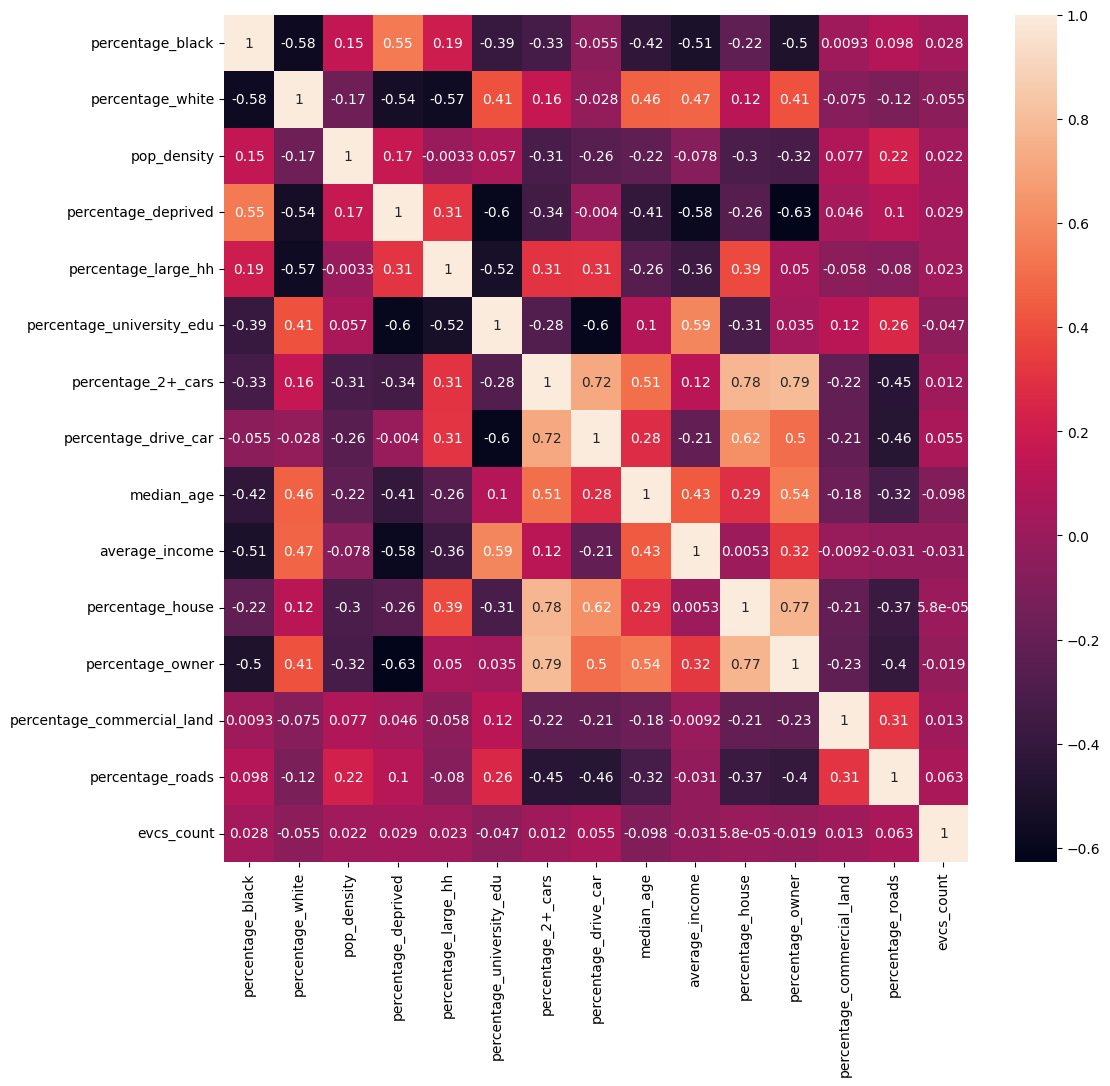

In [183]:
corr_matrix = final_merged_gdf_subset.corr()

# Set the figure size
plt.figure(figsize=(12, 11))

sns.heatmap(corr_matrix, annot=True)
plt.show()

Correlations

## Assumption testing

In [ ]:
# Check for multicollinearity between the variables

## Spatial Autocorrelation

## Regression

## Spatial Regression

NOTES



## References

xxx